In [1]:
# First lets get set up!
from os import path
import nexradaws
import time
import tempfile
import os
import shutil
import pyart
from datetime import datetime, timedelta
from matplotlib import pyplot as plt

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from cartopy.feature import NaturalEarthFeature
import matplotlib.colors as colors


import numpy as np

import pytz
from copy import deepcopy

from math import atan2 as atan2
import warnings
from xmovie import Movie

import xarray
import dask

%matplotlib inline

#Scale bar code. Because I like scale bars
#This code courtesy and gratefully received from Tim Lang @tjlang on twitter

def gc_latlon_bear_dist(lat1, lon1, bear, dist):
    """
    Input lat1/lon1 as decimal degrees, as well as bearing and distance from
    the coordinate. Returns lat2/lon2 of final destination. Cannot be
    vectorized due to atan2.
    """
    re = 6371.1  # km
    lat1r = np.deg2rad(lat1)
    lon1r = np.deg2rad(lon1)
    bearr = np.deg2rad(bear)
    lat2r = np.arcsin((np.sin(lat1r) * np.cos(dist/re)) +
                      (np.cos(lat1r) * np.sin(dist/re) * np.cos(bearr)))
    lon2r = lon1r + atan2(np.sin(bearr) * np.sin(dist/re) *
                          np.cos(lat1r), np.cos(dist/re) - np.sin(lat1r) *
                          np.sin(lat2r))
    return np.rad2deg(lat2r), np.rad2deg(lon2r)
 
 
 
def add_scale_line(scale, ax, projection, color='k',
                  linewidth=None, fontsize=None, fontweight=None):
    """
    Adds a line that shows the map scale in km. The line will automatically
    scale based on zoom level of the map. Works with cartopy.
 
    Parameters
    ----------
    scale : scalar
        Length of line to draw, in km.
    ax : matplotlib.pyplot.Axes instance
        Axes instance to draw line on. It is assumed that this was created
        with a map projection.
    projection : cartopy.crs projection
        Cartopy projection being used in the plot.
 
    Other Parameters
    ----------------
    color : str
        Color of line and text to draw. Default is black.
    """
    frac_lat = 0.1  # distance fraction from bottom of plot
    frac_lon = 0.5  # distance fraction from left of plot
    e1 = ax.get_extent()
    center_lon = e1[0] + frac_lon * (e1[1] - e1[0])
    center_lat = e1[2] + frac_lat * (e1[3] - e1[2])
    # Main line
    lat1, lon1 = gc_latlon_bear_dist(
        center_lat, center_lon, -90, scale / 2.0)  # left point
    lat2, lon2 = gc_latlon_bear_dist(
        center_lat, center_lon, 90, scale / 2.0)  # right point
    if lon1 <= e1[0] or lon2 >= e1[1]:
        warnings.warn('Scale line longer than extent of plot! ' +
                      'Try shortening for best effect.')
    ax.plot([lon1, lon2], [lat1, lat2], linestyle='-',
            color=color, transform=projection, 
            linewidth=linewidth)
    # Draw a vertical hash on the left edge
    lat1a, lon1a = gc_latlon_bear_dist(
        lat1, lon1, 180, frac_lon * scale / 20.0)  # bottom left hash
    lat1b, lon1b = gc_latlon_bear_dist(
        lat1, lon1, 0, frac_lon * scale / 20.0)  # top left hash
    ax.plot([lon1a, lon1b], [lat1a, lat1b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw a vertical hash on the right edge
    lat2a, lon2a = gc_latlon_bear_dist(
        lat2, lon2, 180, frac_lon * scale / 20.0)  # bottom right hash
    lat2b, lon2b = gc_latlon_bear_dist(
        lat2, lon2, 0, frac_lon * scale / 20.0)  # top right hash
    ax.plot([lon2a, lon2b], [lat2a, lat2b], linestyle='-',
            color=color, transform=projection, linewidth=linewidth)
    # Draw scale label
    ax.text(center_lon, center_lat - frac_lat * (e1[3] - e1[2]) / 4.0,
            str(int(scale)) + ' km', horizontalalignment='center',
            verticalalignment='center', color=color, fontweight=fontweight,
            fontsize=fontsize)

    
#https://stackoverflow.com/questions/32237862/find-the-closest-date-to-a-given-date/32237949
def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))


# This is a VERY LAZY function. 
#No testing and if it gets a file Py-ART can not read it will fail, ungracefully

#Function to pull a radar file from AWS

def get_my_radar(connex, site, this_datetime):
    tlocation = tempfile.mkdtemp()
    these_scans = connex.get_avail_scans(this_datetime.year,this_datetime.month, this_datetime.day, site)
    these_times = [scan.scan_time for scan in these_scans]
    targ = this_datetime
    
    #Need to clean
    these_good_scans = []
    these_good_times = []
    for i in range(len(these_scans)):
        if these_times[i] is not None:
            these_good_times.append(these_times[i])
            these_good_scans.append(these_scans[i])
    
    print(len(these_good_scans), len(these_good_times))

    this_nearest_time = nearest(these_good_times, targ)
    this_index = these_good_times.index(this_nearest_time)
    lcn = tlocation
    localfiles = conn.download(these_good_scans[this_index],lcn)
    return pyart.io.read(localfiles.success[0].filepath)

def get_radar_rain(awsconn, radar_time, radar_site='KLOT',  a=300., b=1.4):
    #Lets just repeat this here:
   
    #It needs to be time zone aware

    #If you want the latest use: datetime.utcnow()
    #And like magic, grab the radar file from the Boston WSR-88D
    radar = get_my_radar(awsconn, radar_site, radar_time)
    #Grab a COPY of the reflectivty data from the radar file. 
    #Convert it from dB to linear units ALWAYS DO THIS!
    z_lin = 10.0**(radar.fields['reflectivity']['data'].copy()/10.)

    #Apply the Z-S relation, in this case the WSR-88D Northeast relation
    rain_z = (z_lin/a)**(1./b) 

    #Add the field back to the radar. Use reflectivity as a template
    radar.add_field_like('reflectivity', 'rain_z',  rain_z, replace_existing = True)

    #Update units and metadata
    radar.fields['rain_z']['units'] = 'mm/h'
    radar.fields['rain_z']['standard_name'] = 'rainfall_rate'
    radar.fields['rain_z']['long_name'] = 'rainfall_rate_from_z'
    radar.fields['rain_z']['valid_min'] = 0
    radar.fields['rain_z']['valid_max'] = 500
    radar.fields['rain_z']['comment'] = "a= %s "%a + 'b=%s'%b
    
    return radar

def do_my_plot_rain(iradar, smax=150, app='', outdir=None, window=2, scb=100.):
    
    #Use this line if you want a log colormap
    norm = None #colors.LogNorm(vmin=0.1, vmax=15)
    
    #Where you want the map centered

    centerlat = 29.5
    centerlon = -95.25
    #delta lat lon degrees
    locbox = [centerlon - window, centerlon + window, centerlat - window, centerlat + window]
    
    #Set up the figure
    myf = plt.figure(figsize=[10,10])
    
    #We are going FULL CUSTOM.. This sets up the map panel
    map_panel_axes = [0.05, 0.05, .8, .8]
    
    #Add the map axes. Wse the Platte Carree projection. 
    ax = myf.add_axes(map_panel_axes, projection=ccrs.PlateCarree())

    #Create a radar display.. this makes Py-ART do a bunch of calcs for radar -> Cartesian coords
    myd = pyart.graph.RadarMapDisplay(iradar)
    
    #Plot a PPI, lowest tilt. Use the Homeyer CVD friendly colormap. Range between zere and smax mm/hr
    #Skip the bells and whistles, we will roll our own (embelish)
    myd.plot_ppi_map('rain_z', 0, vmin=0, vmax=smax, ax=ax, embelish=False, colorbar_flag=False,
                    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                    norm=norm)

    #Throw on some gridlines
    gl = ax.gridlines(draw_labels=True,
                      linewidth=2, color='gray', alpha=0.5, linestyle='--')
    gl.ylabels_right = False

    #Grab a high res coast
    coast = NaturalEarthFeature(category='physical', scale='10m',
                                edgecolor='black', name='coastline')
    
    counties = NaturalEarthFeature(category='cultural', scale='10m',
                                edgecolor='black', name='admin_2_counties_lakes', alpha=.2)
    #https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/10m/cultural/ne_10m_admin_2_counties.zip

    #add the coast and state boundaries
    ax.add_feature(cfeature.STATES, facecolor='none', edgecolor='black')
    ax.add_feature(coast, facecolor='none', edgecolor='black')
    ax.add_feature(counties, facecolor='none', edgecolor='black')
    
    #Zoom the plot
    plt.xlim(locbox[0], locbox[1])
    plt.ylim(locbox[2], locbox[3])

    #Add a scale bar, code at the top of the notebook. Thanks Dr Tim Lang from NASA Marshall
    add_scale_line(scb, ax, projection=ccrs.PlateCarree(), 
                   color='black', linewidth=3,
                  fontsize=20,
                  fontweight='bold')

    #Throw on a colorbar
    cbar = plt.colorbar(mappable=myd.plots[0], fraction=.1, shrink=.8)
    pos = cbar.ax.get_position()
    cbar.ax.set_aspect('auto')
    
    #Ok! Folks from the USA like inches.. So make a twin axis for the colorbar and scale to inches
    cax2 = cbar.ax.twinx()
    cax2.set_ylim([0,smax/25.4])
    pos.x0 +=0.05
    cbar.ax.set_position(pos)
    cax2.set_position(pos)

    #Add the text plus any appended text using app keyword.
    cax2.text(2.3,  .15*smax/25.4,'NEXRAD inst. rain Rate (in/h) ' + app,rotation=90)
    cax2.text(-1.8, .15*smax/25.4,'NEXRAD inst. rain Rate (mm/h) ' + app,rotation=90)
    
    #This deals with filename formatting
    ff = time.strptime(iradar.time['units'][14:], '%Y-%m-%dT%H:%M:%SZ')
    strform = time.strftime('%Y%m%d-%H%M%S',ff)
    print(strform)
    if outdir is None:
        base_file = path.expanduser('~') + '/' + strform #dumps in your home dir
    else:
        base_file = outdir + strform
    
    #Save away! Oh and gets rid of transparency.. Tranparency makes animated gifs look odd
    plt.savefig(base_file+'rain.png', facecolor='white', transparent=False)


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
arm_sites = {'Latitude' : [29.670,  29.328],
                         'Longitude' : [-95.059, -95.74],
                         'SiteName' : ['AMF1',  'ANC (approx)']}

In [3]:
mf = xarray.open_mfdataset('/Users/scollis/data/tracer_20220322/yyy-grids-2022032*')

In [4]:
mf.dims

Frozen({'time': 20, 'z': 31, 'y': 101, 'x': 101})

In [5]:
mf.reflectivity

<xarray.DataArray 'reflectivity' (time: 20, z: 31, y: 101, x: 101)>
dask.array<concatenate, shape=(20, 31, 101, 101), dtype=float32, chunksize=(1, 31, 101, 101), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2022-03-22T10:20:36.590000 ... 2022-03-22T...
  * z        (z) float64 0.0 500.0 1e+03 1.5e+03 ... 1.4e+04 1.45e+04 1.5e+04
    lat      (y) float64 dask.array<chunksize=(101,), meta=np.ndarray>
    lon      (x) float64 dask.array<chunksize=(101,), meta=np.ndarray>
  * y        (y) float64 -1e+05 -9.8e+04 -9.6e+04 ... 9.6e+04 9.8e+04 1e+05
  * x        (x) float64 -1e+05 -9.8e+04 -9.6e+04 ... 9.6e+04 9.8e+04 1e+05
Attributes:
    units:          dBZ
    standard_name:  equivalent_reflectivity_factor
    long_name:      Reflectivity
    valid_max:      94.5
    valid_min:      -32.0

In [6]:
ds_lat_lon = mf.set_index(x='lon', y='lat')

<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

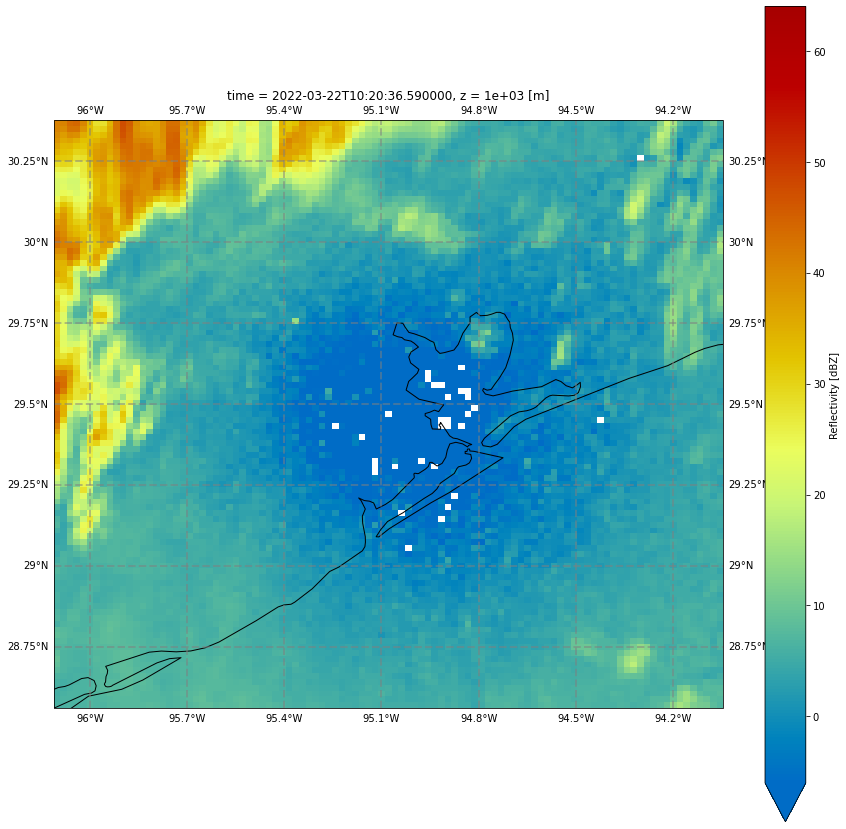

In [7]:
projection = ccrs.PlateCarree()
fig = plt.figure(figsize=[15, 15])
ax = plt.axes(projection=projection)
pc = ds_lat_lon.reflectivity.sel(z=1000, method="nearest",
                        time=ds_lat_lon.time[0]).plot.pcolormesh(cmap=pyart.graph.cm_colorblind.HomeyerRainbow, 
                                                             vmin=-6, vmax=64)
gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

ax.add_feature(cfeature.COASTLINE)
plt.plot


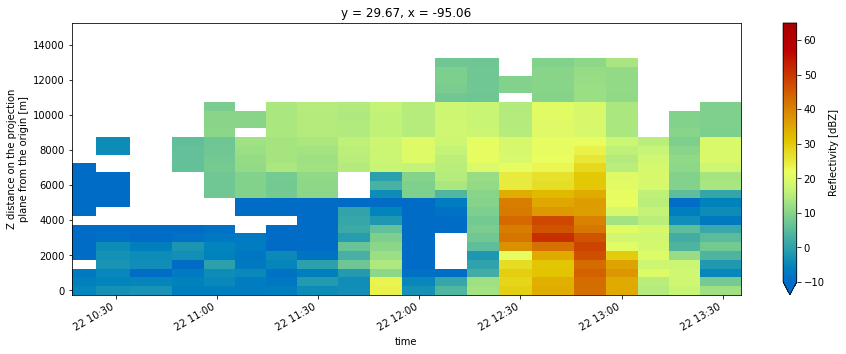

In [8]:
fig = plt.figure(figsize=[15, 5])

ds_lat_lon.sel(x=arm_sites['Longitude'][0], y=arm_sites['Latitude'][0], 
                method='nearest').reflectivity.plot(x='time', 
                                                    cmap=pyart.graph.cm_colorblind.HomeyerRainbow,
                                                    vmin=-10, vmax=65)

In [9]:

warnings.filterwarnings(
    action="ignore",
    category=UserWarning,
    message=r"No `(vmin|vmax)` provided. Data limits are calculated from input. Depending on the input this can take long. Pass `\1` to avoid this step"
)


In [10]:
mov = Movie(ds_lat_lon.sel(z=1000, method="nearest"), framedim='time', 
            input_check=False, vmin=-10, vmax=64,cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
mov.save('hmovie.gif', overwrite_existing=True)

/Users/scollis/miniconda3/envs/chihydro/lib/python3.8/site-packages/xmovie/presets.py:18: UserWarning: No `fieldname` supplied. Defaults to `reflectivity`
  warnings.warn(


Movie created at hmovie.mp4
GIF created at hmovie.gif


![SegmentLocal](hmovie.gif "segment")

In [11]:
def custom_plotfunc(ds, fig, tt, *args, **kwargs):
    ax = plt.axes(projection=projection)
    ds_lat_lon.reflectivity.sel(z=1000, method="nearest").isel(time=tt).plot.pcolormesh(vmin=-10, vmax=64,
                                              cmap=pyart.graph.cm_colorblind.HomeyerRainbow)
    gl = ax.gridlines(draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
    ax.add_feature(cfeature.COASTLINE)
    
    return None, None



    
    


Movie created at bmovie.mp4
GIF created at bmovie.gif


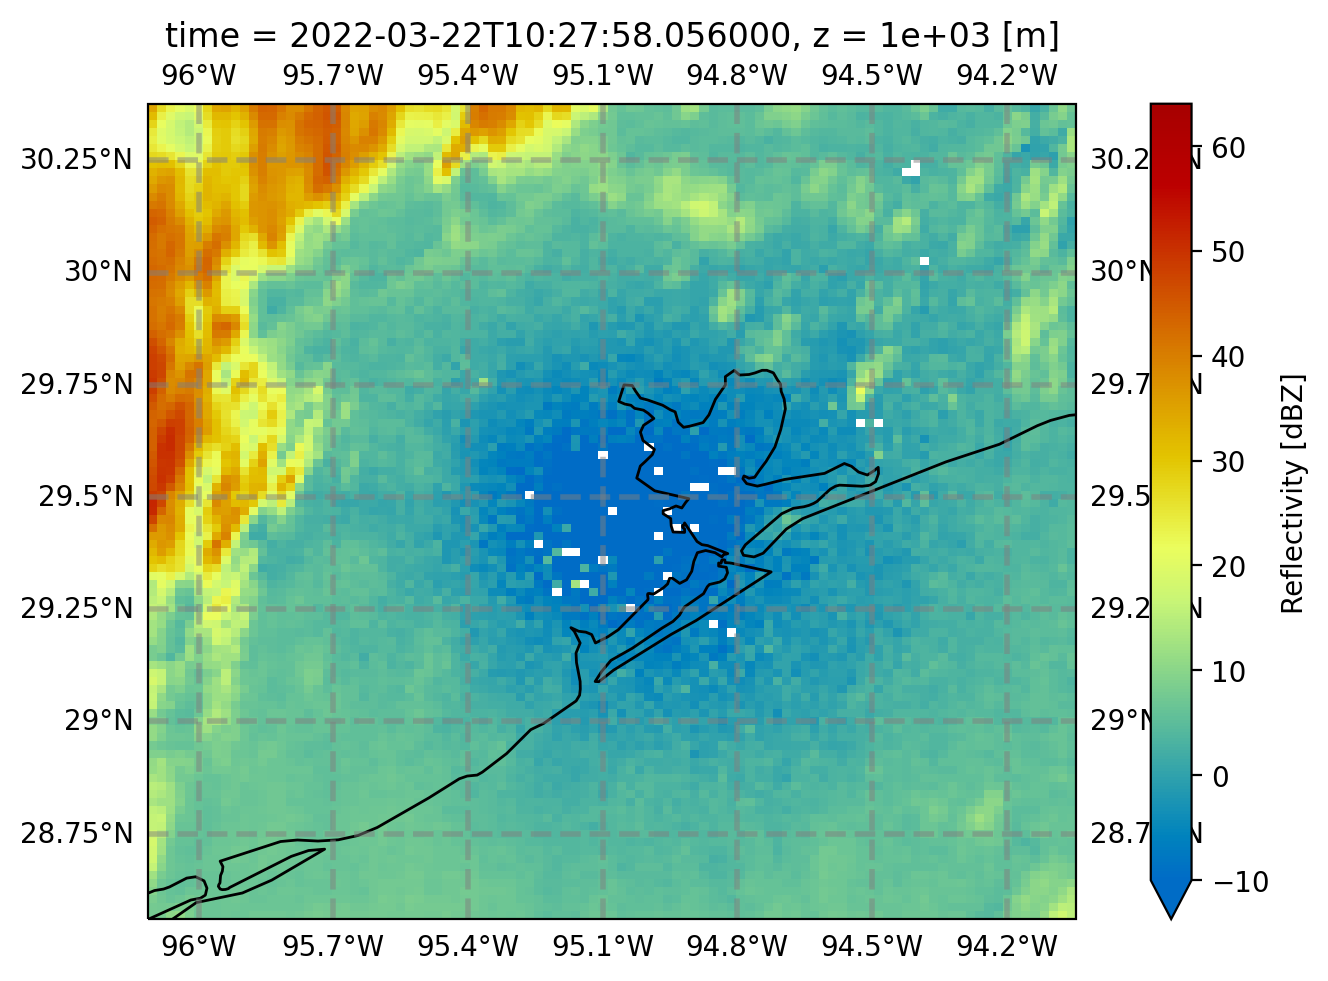

In [12]:
mov_custom = Movie(ds_lat_lon, custom_plotfunc, input_check=False)
mov_custom.preview(1)
mov_custom.save('bmovie.gif', overwrite_existing=True)

![SegmentLocal](bmovie.gif "segment")